###Code and Experiments on CNN Daily News data for 5000 data using LSTM model

In [ ]:
#!pip install q keras==2.2.4
#!pip install q tensorflow==1.15.2
#!pip install q numpy==1.19.5
#!pip install tensorflow-gpu==1.15.2 


#####Installing correct versions of libraries

In [ ]:
!pip install contractions
# !pip install keras
# !pip install tensorflow

     |████████████████████████████████| 106 kB 16.6 MB/s 
     |████████████████████████████████| 287 kB 63.8 MB/s 


#####Importing all libraries

In [ ]:
import numpy as np
import pandas as pd
import os
from zipfile import ZipFile
from pathlib import Path
from io import StringIO
import string  
import nltk
from nltk.tokenize import sent_tokenize, word_tokenize
from nltk.corpus import stopwords 
import nltk
nltk.download("wordnet")
nltk.download('averaged_perceptron_tagger')
from nltk.stem import WordNetLemmatizer
import contractions
from nltk.corpus import wordnet
import re
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Unzipping corpora/wordnet.zip.
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /root/nltk_data...
[nltk_data]   Unzipping taggers/averaged_perceptron_tagger.zip.


In [ ]:
import keras
import tensorflow
print(keras.__version__)
print(tensorflow.__version__)

2.2.4
1.15.2


Using TensorFlow backend.


In [ ]:
device_name = tensorflow.test.gpu_device_name()
if device_name != '/device:GPU:0':
  raise SystemError('GPU device not found')
print('Found GPU at: {}'.format(device_name))

Found GPU at: /device:GPU:0


In [ ]:
from tensorflow.keras.layers import LSTM,Input, GRU, Attention, Embedding, Dense, Concatenate, TimeDistributed   #Layers required to implement the model
from tensorflow.keras.models import Model
from tensorflow.keras.callbacks import EarlyStopping
from keras import backend as K
# from keras import Input

In [ ]:
nltk.download('stopwords')
nltk.download('punkt')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


True

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


#####Initializing data size

In [ ]:
data_size=5000

#####Loading dataset

In [ ]:
from sklearn.model_selection import StratifiedShuffleSplit
import collections
from sklearn.model_selection import train_test_split

In [ ]:
def load_dataset():
  zf = ZipFile('/content/drive/MyDrive/AMLProjectDataset.zip')
  t_df = pd.read_csv(zf.open('cnn_dailymail/train.csv'))
  v_df=pd.read_csv(zf.open('cnn_dailymail/validation.csv'))
  test_df=v_df=pd.read_csv(zf.open('cnn_dailymail/test.csv'))
  
  return t_df,v_df,test_df

#####Function to map POS tags 

In [ ]:
lemmatizer = WordNetLemmatizer()

def get_wordnet_pos(tag):
    tag_dict = {"J": wordnet.ADJ,
                "N": wordnet.NOUN,
                "V": wordnet.VERB,
                "R": wordnet.ADV}

    return tag_dict.get(tag, wordnet.NOUN)


#####Function for Preprocessing data

In [ ]:
def preprocessing(data,data_column):
  train_df = data.drop(['id'], axis=1)
  processed_sent=[]
  for sent in train_df[data_column]:
    processed_sent_sub=re.sub("[\(\[].*?[\)\]]", "", sent)
    processed_sent_sub=contractions.fix(processed_sent_sub)
    processed_sent.append(processed_sent_sub)
  WORD = re.compile(r'\w+')
  sentence = []
  for art in processed_sent:
    words = WORD.findall(art)
    sentence.append(words)
  eng_stopwords = stopwords.words('english')
  punctuation = string.punctuation
  format_sent = []

  for sntc in sentence:
    format_words = []
    for word in sntc:
      if word not in eng_stopwords and word not in punctuation and len(word)>2:
        format_words.append(word.lower())
    format_words = nltk.pos_tag(format_words)
    doc = [lemmatizer.lemmatize(word[0],get_wordnet_pos(word[1][0].upper())) for word in format_words]
    format_sent.append(" ".join(doc))

  return format_sent

#####Adding start (sos) and end (eos) tokens on summary data

In [ ]:
def add_start_end_token(data):
  data_sos_eos=[]
  for x in data:
    data_sos_eos.append('sos '+x+' eos')

  return data_sos_eos

#####Tokenizing and padding data

In [ ]:
def tokenizer(data):
    tokenizer = Tokenizer(oov_token = "<UNK>")
    tokenizer.fit_on_texts(data)
    
    return tokenizer

def token_fit(data,tokenizer):
    sequences=tokenizer.texts_to_sequences(data)
    word_index=tokenizer.word_index
    print(len(max(sequences,key=len)))
    return sequences,len(max(sequences,key=len)),len(word_index)

def padding(sequences,global_max_len):
    padded = pad_sequences(sequences, padding = "post",maxlen=global_max_len)
    return padded,len(padded[0])

#####Declaring size of hidden and embedding layers

In [ ]:
latent_dim = 256
embedding_dim = 256

#####Defining the model

In [ ]:
def models(latent_dim,embedding_dim,ARTICLE_LEN,ART_VOCAB_SIZE,HIGHLIGHT_LEN, HIGH_VOCAB_SIZE):
  encoder_inputs = Input(shape=(ARTICLE_LEN,))
  enc_emb_layer =  Embedding(HIGH_VOCAB_SIZE, embedding_dim,trainable=True)
  encoder_gru1 = LSTM(latent_dim,return_sequences=True,return_state=True,dropout=0.4,recurrent_dropout=0)
  encoder_gru2 = LSTM(latent_dim,return_sequences=True,return_state=True,dropout=0.4,recurrent_dropout=0)
  encoder_gru3= LSTM(latent_dim, return_state=True, return_sequences=True,dropout=0.4,recurrent_dropout=0)

  decoder_inputs = Input(shape=(None,))
  dec_emb_layer = Embedding(HIGH_VOCAB_SIZE, embedding_dim,trainable=True) 
  decoder_gru = LSTM(latent_dim, return_sequences=True, return_state=True,dropout=0.4,recurrent_dropout=0)
  decoder_dense =  TimeDistributed(Dense(HIGH_VOCAB_SIZE, activation='softmax'))
  #attn_layer=AdditiveAttention(use_scale=True)
  #concat_layer=Concatenate(axis=-1)


  enc_emb = enc_emb_layer(encoder_inputs)
  encoder_output1,state_h1, state_c1 = encoder_gru1(enc_emb)
  encoder_output2, state_h2, state_c2 = encoder_gru2(encoder_output1)
  encoder_outputs, state_h, state_c= encoder_gru3(encoder_output2)

  dec_emb = dec_emb_layer(decoder_inputs)
  decoder_outputs, decoder_fwd, decoder_back = decoder_gru(dec_emb,initial_state=[state_h,state_c])

  decoder_outputs = decoder_dense(decoder_outputs)

  model = Model([encoder_inputs, decoder_inputs], decoder_outputs)
  model.summary()

  #encoder testing
  encoder_testing = Model(inputs=encoder_inputs, outputs =[encoder_outputs,state_h,state_c])
  encoder_testing.summary()

  #decoder testing
  decoder_state_input = Input(shape=(latent_dim,))
  decoder_hidden_input = Input(shape=(latent_dim,))
  decoder_hidden_state_input = Input(shape=(ARTICLE_LEN,latent_dim))

  dec_emb2 = dec_emb_layer(decoder_inputs)

  decoder_outputs_inf, state_h_inf, state_c_inf = decoder_gru(dec_emb2, initial_state=[decoder_hidden_input,decoder_state_input])
  print("decoder_outputs_inf",decoder_outputs_inf.shape)
  
  decoder_outputs= decoder_dense(decoder_outputs_inf)
  decoder_testing = Model([decoder_inputs]+[decoder_hidden_state_input,decoder_hidden_input,decoder_state_input], [decoder_outputs]+[state_h_inf,state_c_inf])
  decoder_testing.summary()

  return model,encoder_testing,decoder_testing


#####Loading dataset

In [ ]:
#x_train, x_val, x_test,y_train, y_val,y_test=load_dataset()
train_data,validation_data,test_data=load_dataset()

#####Preprocessing train data, test data and validation data

In [ ]:
format_data=preprocessing(train_data[0:data_size],'article')
format_highlight=preprocessing(train_data[0:data_size],'highlights')
format_val_data = preprocessing(validation_data[0:data_size],'article')
format_val_highlight = preprocessing(validation_data[0:data_size],'highlights')
format_test_data = preprocessing(test_data[0:data_size],'article')
format_test_highlight = preprocessing(test_data[0:data_size],'highlights')

#####Exploring length of text and summary from the data 

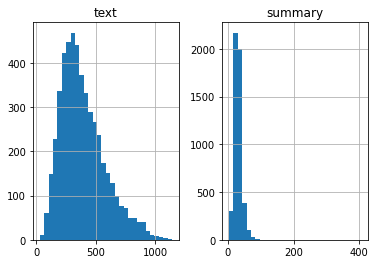

In [ ]:
import matplotlib.pyplot as plt

text_word_count = []
summary_word_count = []

# populate the lists with sentence lengths
for i in format_data:
      text_word_count.append(len(i.split()))

for i in format_highlight:
      summary_word_count.append(len(i.split()))

length_df = pd.DataFrame({'text':text_word_count, 'summary':summary_word_count})

length_df.hist(bins = 30)
plt.show()

#####Removing Outliers from data

In [ ]:
max_text_len=1000
max_summary_len=100

In [ ]:
short_text=[]
short_summary=[]
short_val_summary=[]
short_val_text=[]
short_test_summary=[]
short_test_text=[]
for i in range(len(format_data)):
    if(len(format_highlight[i].split())<=max_summary_len and len(format_data[i].split())<=max_text_len):
        short_summary.append(format_highlight[i])
        short_text.append(format_data[i])


for i in range(len(format_val_data)):
    if(len(format_val_highlight[i].split())<=max_summary_len and len(format_val_data[i].split())<=max_text_len):
        short_val_summary.append(format_val_highlight[i])
        short_val_text.append(format_val_data[i])

for i in range(len(format_test_data)):
    if(len(format_test_highlight[i].split())<=max_summary_len and len(format_test_data[i].split())<=max_text_len):
        short_test_summary.append(format_test_highlight[i])
        short_test_text.append(format_test_data[i])

In [ ]:
format_highlight=short_summary
format_data=short_text

format_val_highlight=short_val_summary
format_val_data=short_val_text

format_test_highlight=short_test_summary
format_test_data=short_test_text

#####Tokenizing data 

In [ ]:
#padded_seq,ART_VOCAB_SIZE,ARTICLE_LEN=tokenizer(format_data)
#padded_seq,ART_VOCAB_SIZE,ARTICLE_LEN=tokenizer(format_data)
X_token=tokenizer(format_data)
sos_eos_highlight=add_start_end_token(format_highlight)
Y_token=tokenizer(sos_eos_highlight)

seq,max_len_data,ART_VOCAB_SIZE=token_fit(format_data,X_token)
seq_highlight,max_len_data_highlights,HIGH_VOCAB_SIZE=token_fit(sos_eos_highlight,Y_token)

#padded_val_seq_data, VAL_ART_VOCAB_SIZE, VAL_ART_LEN = tokenizer(format_val_data)
val_seq_data, max_len_val_data, VAL_ART_VOCAB_SIZE= token_fit(format_val_data,X_token)
sos_eos_val_highlight=add_start_end_token(format_val_highlight)
#padded_val_seq_highlight, VAL_HIGH_VOCAB_SIZE, VAL_HIGHLIGHT_LEN = tokenizer(sos_eos_val_highlight)
val_seq_highlight,max_len_val_data_highlights, VAL_HIGH_VOCAB_SIZE= token_fit(sos_eos_val_highlight,Y_token)

#padded_test_seq_data, TEST_ART_VOCAB_SIZE, TEST_ART_LEN = tokenizer(format_test_data)
test_seq_data, max_len_test_data, TEST_ART_VOCAB_SIZE= token_fit(format_test_data,X_token)
sos_eos_test_highlight=add_start_end_token(format_test_highlight)
#padded_test_seq_highlight, TEST_HIGH_VOCAB_SIZE, TEST_HIGHLIGHT_LEN = tokenizer(sos_eos_test_highlight)
test_seq_highlight, max_len_test_data_highlights, TEST_HIGH_VOCAB_SIZE= token_fit(sos_eos_test_highlight,Y_token)

global_max_len_data=max([max_len_data,max_len_val_data,max_len_test_data])
global_max_len_data_highlights=max([max_len_data_highlights,max_len_val_data_highlights,max_len_test_data_highlights])

padded_seq,ARTICLE_LEN=padding(seq,max_text_len)
padded_val_seq_data, VAL_ART_LEN = padding(val_seq_data,max_text_len)
padded_test_seq_data, TEST_ART_LEN = padding(test_seq_data,max_text_len)

padded_seq_highlight,HIGHLIGHT_LEN=padding(seq_highlight,max_summary_len)
padded_val_seq_highlight, VAL_HIGHLIGHT_LEN = padding(val_seq_highlight,max_summary_len)
padded_test_seq_highlight, TEST_HIGHLIGHT_LEN = padding(test_seq_highlight,max_summary_len)
#print(words)

1000
98
997
98
997
98


In [ ]:
global_max_highlight_vocab_size = max(HIGH_VOCAB_SIZE,VAL_HIGH_VOCAB_SIZE,TEST_HIGH_VOCAB_SIZE)

global_max_article_vocab_size = max(ART_VOCAB_SIZE,VAL_ART_VOCAB_SIZE,TEST_ART_VOCAB_SIZE)

In [ ]:
K.clear_session()

#####Creating model

Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor
Instructions for updating:
If using Keras pass *_constraint arguments to layers.
done
done 2
Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 1000)]       0                                            
__________________________________________________________________________________________________
embedding (Embedding)           (None, 1000, 256)    5063424     input_1[0][0]                    
__________________________________________________________________________________________________
lstm (LSTM)                     [(None, 1000, 256),  525312      embedding[0][0]                  
_________________________________________________________________________________

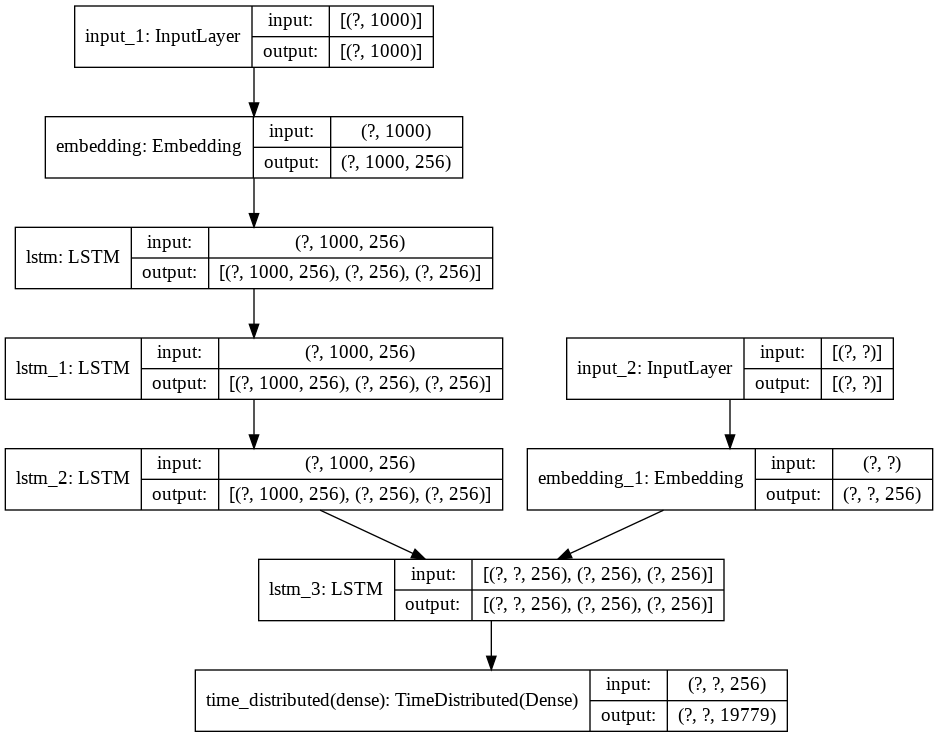

In [ ]:
train_mod,encoder_mod,decode_mod=models(latent_dim,embedding_dim,max_text_len,global_max_article_vocab_size+1,max_summary_len, global_max_highlight_vocab_size+1)
from tensorflow.keras.utils import plot_model

plot_model(train_mod, to_file='model_plot.png', show_shapes=True, show_layer_names=True)


#####Compiling and Training Model

In [ ]:
from tensorflow.keras import callbacks
class CustomCallback(callbacks.Callback):
    def on_epoch_end(self, epoch, logs=None):
        print("\n Epoch {} ended".format(epoch))
        #print(seq2seq.model.layers[1].get_weights())

In [ ]:
with tensorflow.device("/gpu:0"):
  train_mod.compile(optimizer='rmsprop' , loss='sparse_categorical_crossentropy' , metrics=['accuracy'])
  es = EarlyStopping(monitor='loss', mode='min', verbose=1,patience=5)
  history = train_mod.fit([padded_seq,padded_seq_highlight[:,:-1]], padded_seq_highlight.reshape(padded_seq_highlight.shape[0],padded_seq_highlight.shape[1], 1)[:,1:] ,epochs=50,callbacks=[es],batch_size= 64, validation_data=([padded_val_seq_data,padded_val_seq_highlight[:,:-1]], padded_val_seq_highlight.reshape(padded_val_seq_highlight.shape[0],padded_val_seq_highlight.shape[1], 1)[:,1:]))


Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where
Train on 4975 samples, validate on 4972 samples
Epoch 1/50
4975/4975 [==============================] - 399s 80ms/sample - loss: 3.3415 - acc: 0.6717 - val_loss: 2.8734 - val_acc: 0.6673
Epoch 2/50
4975/4975 [==============================] - 411s 83ms/sample - loss: 2.6611 - acc: 0.6909 - val_loss: 2.8655 - val_acc: 0.6727
Epoch 3/50
4975/4975 [==============================] - 401s 81ms/sample - loss: 2.6239 - acc: 0.6919 - val_loss: 2.8610 - val_acc: 0.6746
Epoch 4/50
4975/4975 [==============================] - 397s 80ms/sample - loss: 2.5991 - acc: 0.6925 - val_loss: 2.8519 - val_acc: 0.6752
Epoch 5/50
4975/4975 [==============================] - 397s 80ms/sample - loss: 2.5757 - acc: 0.6931 - val_loss: 2.8477 - val_acc: 0.6755
Epoch 6/50
4975/4975 [==============================] - 396s 80ms/sample - loss: 2.5530 - acc: 0.6934 - val_loss: 2.8533 - val_acc: 0.6760
Epoch 7/50
4975/4975 [==

#####Plotting training and validation accuracy

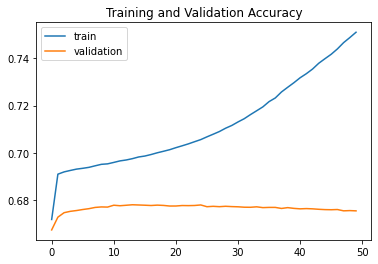

In [ ]:
from matplotlib import pyplot
pyplot.plot(history.history['acc'], label='train') 
pyplot.plot(history.history['val_acc'], label='validation') 
pyplot.title("Training and Validation Accuracy")
pyplot.legend() 
pyplot.show()

#####Plotting training and validation loss

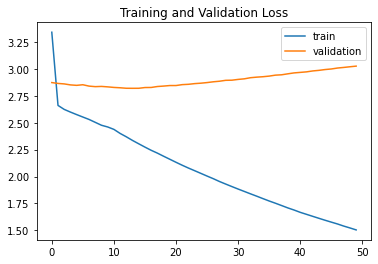

In [ ]:
pyplot.plot(history.history['loss'], label='train') 
pyplot.plot(history.history['val_loss'], label='validation') 
pyplot.title("Training and Validation Loss")
pyplot.legend() 
pyplot.show()


#####Testing Model

In [ ]:
def infer_results(padded_test_seq_data):
  All_sentences = []
  for i in range(len(padded_test_seq_data)):
    inputseq = padded_test_seq_data[i].reshape(1,max_text_len)
    encoder_op,encoder_h,encoder_c=encoder_mod.predict(inputseq)
    infered_op = np.zeros((1,1))

    infered_op[0,0]  = 2
    decoded_sent=[]
    reverse_words=Y_token.index_word
    while True:
      decoder_op,decoder_h,decoder_c=decode_mod.predict([infered_op]+[encoder_op,encoder_h,encoder_c])
      token_index=np.argmax(decoder_op[0,-1,:])
      # print(token_index)
      token=reverse_words[token_index]

      if token!="eos":
        decoded_sent.append(token)

      if token=="eos" or len(decoded_sent)>=global_max_len_data_highlights:
        break

      infered_op[0,0]  = token_index
      encoder_h=decoder_h
      encoder_c=decoder_c

    print("format_test_data[i]:   ",format_test_data[i])
    print("format_test_highlight[i]:   ",format_test_highlight[i])
    sent = " ".join(decoded_sent)
    All_sentences.append(sent)
    print("OUTPUT:   ",sent)
    print("\n")
  return All_sentences

All_sentences = infer_results(padded_test_seq_data)

Streaming output truncated to the last 5000 lines.
format_test_data[i]:    somerset new limited over captain alfonso thomas agree coach delhi daredevils indian premier league month veteran seamer thomas still recover break ankle yet fit selection somerset first county championship fixture home durham therefore free club bless take short term coach appointment delhi april veteran somerset seamer agree deal become delhi daredevil coach indian premier league somerset director cricket matthew maynard say the chance arise take short term coach role delhi great experience wish move coaching future thomas continue rehabilitation india hope fit time somerset second championship fixture middlesex end month say enjoyed time player ipl great opportunity gain coach experience short term work gary kirsten really look forward
format_test_highlight[i]:    alfonso thomas coach indian premier league month veteran somerset bowler agree deal delhi daredevils 2015 edition indian premier league begin april

#####Evaluating Model

In [ ]:
!pip install rouge

In [ ]:
from rouge import Rouge
rouge = Rouge()

In [ ]:
presicion = []
recall = []
f1 = []
print(len(All_sentences))
for (h, r) in zip(All_sentences, format_test_highlight):
    if h != "" and r != "":
      score = rouge.get_scores(h, r)
      print(score)
      s = score[0]['rouge-1']
      presicion.append(s["p"])
      recall.append(s["r"])
      f1.append(s["f"])

print("Precision:",sum(presicion)/len(presicion))
print("Recall:", sum(recall)/len(recall))
print("F1:",sum(f1)/len(f1))

4972
[{'rouge-1': {'r': 0.043478260869565216, 'p': 0.08333333333333333, 'f': 0.05714285263673504}, 'rouge-2': {'r': 0.0, 'p': 0.0, 'f': 0.0}, 'rouge-l': {'r': 0.043478260869565216, 'p': 0.08333333333333333, 'f': 0.05714285263673504}}]
[{'rouge-1': {'r': 0.0, 'p': 0.0, 'f': 0.0}, 'rouge-2': {'r': 0.0, 'p': 0.0, 'f': 0.0}, 'rouge-l': {'r': 0.0, 'p': 0.0, 'f': 0.0}}]
[{'rouge-1': {'r': 0.05, 'p': 0.14285714285714285, 'f': 0.07407407023319637}, 'rouge-2': {'r': 0.0, 'p': 0.0, 'f': 0.0}, 'rouge-l': {'r': 0.05, 'p': 0.14285714285714285, 'f': 0.07407407023319637}}]
[{'rouge-1': {'r': 0.0, 'p': 0.0, 'f': 0.0}, 'rouge-2': {'r': 0.0, 'p': 0.0, 'f': 0.0}, 'rouge-l': {'r': 0.0, 'p': 0.0, 'f': 0.0}}]
[{'rouge-1': {'r': 0.09375, 'p': 0.15789473684210525, 'f': 0.11764705414840465}, 'rouge-2': {'r': 0.0, 'p': 0.0, 'f': 0.0}, 'rouge-l': {'r': 0.0625, 'p': 0.10526315789473684, 'f': 0.07843136787389493}}]
[{'rouge-1': {'r': 0.0, 'p': 0.0, 'f': 0.0}, 'rouge-2': {'r': 0.0, 'p': 0.0, 'f': 0.0}, 'rouge-l': {